# План домашних заданий


- Описание задачи и знакомство с данными
- Домашнее задание 1. Генерация и фильтрация признаков
- Домашнее задание 2. Прогноз времени и вида поломки машин, настройка ML-модели
- Дополнительное задание. Визуализация прогнозов, ошибок модели и важности признаков
- Домашнее задание 3. Оптимизация. Тюнинг гиперпараметров с помощью `Optuna`
- Домашнее задание 4. Блендинг
- Домашнее задание 5. Парсинг внешних данных и оптимизация памяти
- Отправка финального решения на лидерборд на Kaggle

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# <center id="part0"> Описание задачи

**Предыстория:**  мы работаем с каршеринговой компанией, которая управляет крупным автопарком машин. Наша цель — предотвратить длительные периоды простоя машин из-за поломок через своевременное обслуживание и ремонт.


**Идея для решения проблемы:** создать приоритизированный список обхода машин. Этот список поможет технической бригаде сосредоточиться на автомобилях, которые наиболее вероятно выйдут из строя в ближайшее время.


**Как компания решает задачу:**

* Собирает данные о поездках и состоянии машин до поломок.

* Нанимает Data Scientist, чтобы он смог использовать эти данные для анализа и прогнозирования характера поломок.

**Важный момент**: задачи этого специалиста (Data Scientist) предстоит выполнять вам.

## <center> Знакомство с данными

### Информация про машины с таргетом (основной датасет)

In [ ]:
car_train = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/car_train.csv')
car_train.sample(5)

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class
2114,B88120693S,Renault Sandero,standart,petrol,3.68,2014,62343,2020,63.51,engine_ignition
2279,S20524077t,Hyundai Solaris,economy,petrol,3.78,2011,2062,2018,22.40,gear_stick
68,q-1861373D,Smart ForTwo,economy,petrol,4.46,2013,43385,2016,47.46,another_bug
1468,q22680253Z,Audi A3,premium,petrol,3.86,2014,63825,2019,60.36,engine_ignition
1551,e-1100534R,Nissan Qashqai,standart,petrol,4.74,2013,46315,2019,26.62,electro_bug


- `car_id` — идентификатор машины
- `model` / `car_type` / `fuel_type` — марка, класс и тип топлива машины
- `car_rating` / `riders` — общий рейтинг и общее число поездок к концу 2021 года
- `year_to_start` / `year_to_work` — год выпуска машины и год начала работы в автопарке
- `target_reg` — количество дней до поломки
- `target_class` — класс поломки (всего 9 видов)

### Информация про поездки

In [ ]:
rides_info = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/rides_info.csv')
rides_info.sample(5)

,user_id,car_id,ride_id,ride_date,rating,ride_duration,ride_cost,speed_avg,speed_max,stop_times,distance,refueling,user_ride_quality,deviation_normal
116540,m12112662b,I-2947258i,A1J,2020-03-12,9.93,40190,643033,31,65.091841,1,1.281675e+06,0,3.792576,-9.351
217271,r19061105D,P-7445835e,C1U,2020-03-04,3.12,40,395,41,68.000000,1,5.373436e+02,0,12.179512,-2.399
532707,I15897507a,l17843143j,q1U,2020-02-19,4.36,29,400,55,64.092837,0,1.579933e+03,0,NaN,-25.554
260823,q71466786B,S-2166867a,w1n,2020-03-31,9.16,35,345,50,63.000000,0,1.769659e+03,0,-7.681154,-49.101
671584,i12721459q,v-4393931r,c1G,2020-03-03,7.03,40,593,36,65.188769,0,1.499619e+03,0,-2.917620,-2.200


- `user_id` / `car_id` / `ride_id` — идентификаторы водителя, машины, поездки соответственно
- `ride_date` / `rating` — дата поездки и рейтинг, поставленный водителем
- `ride_duration` / `distance` / `ride_cost` —  длительность (время),  пройденное расстояние, стоимость поездки
- `speed_avg` / `speed_max` — средняя и максимальная скорости поездки соответственно
- `stop_times` / `refueling` — количество остановок (паузы) и флаг: была ли дозаправка
- `user_ride_quality` — оценка манеры вождения водителя машины, определенная скоринговой ML-системой сервиса
- `deviation_normal` — общий показатель датчиков о состоянии машины, относительно эталонных показателей (нормы)

### Информация про водителей

In [ ]:
driver_info = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/driver_info.csv')
driver_info.sample(5)

,age,user_rating,user_rides,user_time_accident,user_id,sex,first_ride_date
13680,34,9.3,285,13.0,Z16094070t,0,2020-4-25
3226,22,7.9,1908,0.0,s16669610b,1,2021-9-24
425,34,7.5,689,4.0,r10085235V,1,2020-8-12
8716,28,8.3,565,8.0,I69353533C,0,2019-6-18
3228,45,7.4,199,2.0,J14728390x,0,2019-9-23


- `user_id` / `age` / `sex` — идентификатор, возраст и пол водителя, соответственно
- `user_rating` — общий рейтинг пользователя за все поездки к концу 2021 года
- `user_rides` — общее количество поездок к концу 2021 года
- `user_time_accident` — число инцидентов (это могли быть аварии/штрафы/эвакуация машины)  
- `first_ride_date` — дата первой поездки

### Информация про ремонт машин

In [ ]:
fix_info = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/fix_info.csv')
fix_info.sample(5)

,car_id,worker_id,fix_date,work_type,destroy_degree,work_duration
47706,u-7756149A,HY,2020-2-12 21:44,reparking,1.0,25
124102,O-1778305H,ZL,2019-7-24 12:10,repair,3.7,5
64632,Q15261602W,VL,2020-3-4 8:3,repair,5.5,18
29039,w-1503651B,TY,2019-11-9 11:43,refuel,1.0,29
97692,n21726530a,ZL,2019-10-16 0:42,repair,5.0,30


- `worker_id` / `car_id` — идентификатор работника и машины
- `work_type` / `work_duration` — тип и длительность (в часах) проводимой работы
- `destroy_degree` — степень износа/поврежденности машины в случае поломки
- `fix_date` — время начала ремонта (снятия машины с линии)

# Домашнее задание 1. Генерация и фильтрация признаков

<center> <img src="https://ucarecdn.com/bf4c772d-b67a-42ae-a48b-cfd83910b0a2/" width=700>

<div class="alert alert-info">

**Цель блока** — сгенерировать признаки из дополнительных датасетов и добавить их к основному датасету, произвести фильтрацию признаков.

    
## Задание 1. Генерация признаков из дополнительных датасетов (6 баллов)

<div class="alert alert-info">

1. Возьмите датасет `rides_info` с информацией о поездках и проведите группировку по каждой машине отдельно.

2. Для каждой машины (то есть для каждого `car_id`) подсчитайте несколько признаков:
  - минимальный рейтинг за все поездки;
  - средний рейтинг за все поездки;
  - общее количество километров, которое машина проехала;
  - максимальная скорость;
  - общее количество поездок для каждой машины.

3. Добавьте минимум 3 признака на свой выбор.

4. Сделайте соединение таблиц — вспомните про методы соединения и выберите подходящий для этого случая.

5. Подключите информацию про водителей (`driver_info`) и про ремонт машин (`fix_info`). Добавьте минимум 3 любых признака с каждого датасета.


<h4> Критерии оценивания </h4>
    
- Добавлены 5 обязательных и минимум 3 любых признака из датасета `rides_info` — 2 балла.
- Добавлены минимум 3 любых признака из датасета `driver_info` — 2 балла.
- Добавлены минимум 3 любых признака из датасета `fix_info` — 2 балла.

</div>

<div class="alert alert-success">
    
<h4> Советы по Feature Engineering</h4>
    
- Начинайте с сырых данных.
- Используйте все доступные данные. Покрывайте признаками всю имеющуюся информацию в данных.
- Формулируйте предположения: от чего зависит таргет?
- Смотрите визуально на классы/ошибки и делайте предположения. Какие полезны?
- Помните, что слишком много признаков может быть вредно. Потом придется отфильтровывать.
    
<h4> Полезные источники </h4>
    
- Занятие про Feature Engineering.
- Занятие про Feature Selection.
- [Max Kuhn and Kjell Johnson. Feature Engineering and Selection: A Practical Approach for Predictive Models](http://www.feat.engineering/).

### Расчет признаков

In [ ]:
rides_agg=rides_info.groupby('car_id', as_index=False).agg(
    # Обязательные
    min_rating = ('rating', 'min'),
    mean_rating = ('rating', 'mean'),
    sum_distance = ('distance', 'sum'),
    max_speed = ('speed_max', 'max'),
    total_rides = ('ride_id', 'count'),
    # Дополнительные
    mean_duration=('ride_duration', 'mean'),  # средняя длительность поездок
    sum_ride_cost=('ride_cost', 'sum'),  # общая сумма оплаты за поездки
    min_ride_date=('ride_date', 'min'),  # дата и время первой поездки
)
rides_agg.head()

,car_id,min_rating,mean_rating,sum_distance,max_speed,total_rides,mean_duration,sum_ride_cost,min_ride_date
0,A-1049127W,0.1,4.255172,1.125753e+07,179.729652,174,1289.034483,2645050,2020-01-01
1,A-1079539w,0.1,4.088046,1.912765e+07,184.505566,174,2148.810345,4699301,2020-01-01
2,A-1162143G,0.1,4.662299,2.995194e+06,180.000000,174,479.017241,800344,2020-01-01
3,A-1228282M,0.1,4.225172,1.793685e+07,182.446070,174,2167.534483,4764037,2020-01-01
4,A-1339912r,0.1,4.690115,1.202552e+07,152.000000,174,1436.614943,2816285,2020-01-01


In [ ]:
# Присоединим к основному датасету
tmp = rides_info.merge(rides_agg, on="car_id", how="left")
tmp = car_train.merge(tmp, on="car_id", how="left")

In [ ]:
tmp.head()

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class,...,user_ride_quality,deviation_normal,min_rating,mean_rating,sum_distance,max_speed,total_rides,mean_duration,sum_ride_cost,min_ride_date
0,y13744087j,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,108.53,another_bug,...,0.524750,0.0,0.1,4.737759,1.214131e+07,180.855726,174,1635.770115,3498596,2020-01-01
1,y13744087j,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,108.53,another_bug,...,1.723151,0.0,0.1,4.737759,1.214131e+07,180.855726,174,1635.770115,3498596,2020-01-01
2,y13744087j,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,108.53,another_bug,...,0.876440,-0.0,0.1,4.737759,1.214131e+07,180.855726,174,1635.770115,3498596,2020-01-01
3,y13744087j,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,108.53,another_bug,...,1.274242,-0.0,0.1,4.737759,1.214131e+07,180.855726,174,1635.770115,3498596,2020-01-01
4,y13744087j,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,108.53,another_bug,...,0.952363,-0.0,0.1,4.737759,1.214131e+07,180.855726,174,1635.770115,3498596,2020-01-01


In [ ]:
# Соединение таблиц rides_info и driver_info
tmp = tmp.merge(driver_info, on="user_id", how="left")
tmp = tmp.merge(fix_info, on="car_id", how="left")

In [ ]:
tmp.sample(5)

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class,...,user_rating,user_rides,user_time_accident,sex,first_ride_date,worker_id,fix_date,work_type,destroy_degree,work_duration
2996511,r12485993Y,Kia Rio,economy,petrol,3.24,2015,70966,2022,24.38,gear_stick,...,7.9,1043,4.0,0,2019-2-14,DO,2019-8-14 16:10,repair,10.0,57
8792987,j26265780j,Skoda Rapid,economy,petrol,3.94,2014,59947,2017,50.29,engine_ignition,...,8.6,2156,11.0,0,2021-11-28,TZ,2019-9-18 17:49,repair,5.0,16
2533242,X27634860c,VW Polo,economy,petrol,5.16,2014,55548,2016,31.69,wheel_shake,...,8.1,1899,69.0,1,2018-4-6,AD,2020-6-12 4:57,reparking,1.0,22
2553380,A-1049127W,Hyundai Solaris,economy,petrol,4.68,2011,1990,2016,46.28,engine_overheat,...,7.9,352,3.0,0,2019-8-14,NW,2020-6-23 0:5,repair,5.5,22
13551909,O-7780124Q,Skoda Rapid,economy,petrol,4.62,2013,46470,2019,100.93,another_bug,...,8.1,744,7.0,0,2019-4-30,EJ,2019-5-7 9:51,repair,5.2,11


In [ ]:
car_info=tmp
# Cредний возраст водителей данной модели машины
car_info['avg_driver_age'] = car_info.groupby('model')['age'].transform('mean')
# Cредний рейтинг водителей данной модели машины
car_info['avg_driver_rating'] = car_info.groupby('model')['user_rating'].transform('mean')
# Общее количество инцидентов с водителями данной модели машины
car_info['total_driver_incidents'] = car_info.groupby('model')['user_time_accident'].transform('sum')
# Среднее время ремонта для данной модели машины
car_info['avg_repair_duration_per_model'] = car_info.groupby('model')['work_duration'].transform('mean')
# Среднее количество ремонтов для данной модели машины
car_info['avg_repairs_per_model'] = car_info.groupby('model')['work_duration'].transform('count')
# Процент инцидентов с высокой степенью разрушения
threshold_destruction = 5
car_info['percent_high_destruction_incidents'] = (car_info['destroy_degree'] > threshold_destruction).mean()

In [ ]:
car_info.head()

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class,...,fix_date,work_type,destroy_degree,work_duration,avg_driver_age,avg_driver_rating,total_driver_incidents,avg_repair_duration_per_model,avg_repairs_per_model,percent_high_destruction_incidents
0,y13744087j,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,108.53,another_bug,...,2019-8-10 9:29,reparking,1.0,28,33.940331,8.001092,7981246.0,26.328268,835896,0.291468
1,y13744087j,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,108.53,another_bug,...,2019-2-9 10:49,repair,4.5,7,33.940331,8.001092,7981246.0,26.328268,835896,0.291468
2,y13744087j,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,108.53,another_bug,...,2020-4-8 10:23,reparking,1.0,27,33.940331,8.001092,7981246.0,26.328268,835896,0.291468
3,y13744087j,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,108.53,another_bug,...,2019-5-23 10:42,reparking,1.0,30,33.940331,8.001092,7981246.0,26.328268,835896,0.291468
4,y13744087j,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,108.53,another_bug,...,2020-7-24 18:32,repair,5.3,12,33.940331,8.001092,7981246.0,26.328268,835896,0.291468


In [ ]:
car_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13970460 entries, 0 to 13970459
Data columns (total 48 columns):
 #   Column                              Dtype  
---  ------                              -----  
 0   car_id                              object 
 1   model                               object 
 2   car_type                            object 
 3   fuel_type                           object 
 4   car_rating                          float64
 5   year_to_start                       int64  
 6   riders                              int64  
 7   year_to_work                        int64  
 8   target_reg                          float64
 9   target_class                        object 
 10  user_id                             object 
 11  ride_id                             object 
 12  ride_date                           object 
 13  rating                              float64
 14  ride_duration                       int64  
 15  ride_cost                           int64  
 16

In [ ]:
# Удаляем 95% случайных строк из DataFrame, так как у меня закончилась ОП
car_info = car_info.sample(frac=0.05, random_state=42)

In [ ]:
car_info.to_csv('output.csv')

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Задание 2. Применение методов фильтрации признаков (4 балла)

<center> <img src="https://ucarecdn.com/d1b4bc78-fd04-44fb-bdbf-0a63355b7384/" width=700>

1. Выберите и примените любые 3 (можно и больше) метода фильтрации, которые указаны выше или в ноутбуке по фильтрации из полезных ссылок.
2. Проинтерпретируйте результаты и сделайте выводы.


<h4> Критерии оценивания </h4>
    
- Применены методы фильтрации — 1 балл за каждый метод, максимум 3 балла.
- Сделаны выводы на основе примененных методов —1 балл.
</div>

### Советы по Feature Selection

<div class="alert alert-info">

<h3><center>Зачем отбирать признаки</center></h3>
    
**Основные причины**:
    
- Главная причина: с увеличением количества признаков часто падает точность предсказания модели, а некоторые модели и вовсе перестают адекватно работать. Так происходит, если в данных большое количество мусорных фичей (почти не коррелирующих с таргетом).

- Если фичей очень много, то данные перестают помещаться в память и существенно увеличивают время обучения модели, особенно если мы тестируем несколько алгоритмов или ансамбль. Также важно учитывать, что платформы имеют ограничения на длительность одной сессии (в Kaggle — 12 часов) и лимиты по потребляемой памяти.

- Даже если точность не снижается, есть риск, что модель опирается на шумные фичи, что снизит стабильность прогноза на приватной выборке.


<b>Что удалить сразу:</b>
    
- константы;
- уникальные значения (в том числе в тесте; как правило, это ID-шники по типу `car_id`).
    
<b>Какие методы использовать:</b>
    
- `Линейная корреляция`.
- `Phik` — тоже корреляция, но на стероидах ([туториал на Medium](https://towardsdatascience.com/phik-k-get-familiar-with-the-latest-correlation-coefficient-9ba0032b37e7)).
- `Permutation importance` (из `scikit-learn`).
- `SHAP values` (из библиотеки `shap`).
- `CatBoost Feature Selection` (рекурсивные методы).
    

In [1]:
!pip install phik shap catboost -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 686.1/686.1 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 6.2 MB/s eta 0:00:00


In [3]:
import phik
import shap
import catboost
from phik import phik_matrix
from phik.report import plot_correlation_matrix
from phik import report
from catboost import CatBoostRegressor, Pool

In [6]:
car_info=pd.read_csv('/content/drive/MyDrive/data/output.csv', index_col=0)

In [7]:
car_info.head()

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class,...,fix_date,work_type,destroy_degree,work_duration,avg_driver_age,avg_driver_rating,total_driver_incidents,avg_repair_duration_per_model,avg_repairs_per_model,percent_high_destruction_incidents
4213980,n34490222d,Smart ForFour,economy,petrol,3.48,2017,128022,2015,42.47,break_bug,...,2019-2-9 9:50,reparking,1.0,28,33.914340,8.014522,9028079.0,26.649401,943950,0.291468
13940008,B-3513567K,Mercedes-Benz E200,business,petrol,4.66,2013,48944,2020,46.05,engine_fuel,...,2019-11-5 4:13,repair,7.0,37,35.268211,8.176967,1344041.0,26.032870,137634,0.291468
8325673,W-1261565K,Kia Sportage,standart,petrol,5.16,2015,86859,2018,111.81,another_bug,...,2019-10-22 8:17,repair,5.7,26,33.862578,7.996548,8353168.0,25.855336,880440,0.291468
1342529,n-1751164y,Smart ForTwo,economy,petrol,4.58,2015,87819,2017,26.45,gear_stick,...,2020-4-6 8:4,reparking,1.0,29,34.083019,7.992041,7214113.0,26.211809,777954,0.291468
5713481,e14382410l,Smart ForTwo,economy,petrol,3.22,2015,82106,2018,23.22,break_bug,...,2019-9-22 13:49,reparking,1.0,32,34.083019,7.992041,7214113.0,26.211809,777954,0.291468


In [7]:
cols2drop = ['car_id', 'deviation_normal_count', 'fix_date', 'ride_id', 'user_id', 'first_ride_date', 'total_rides', 'percent_high_destruction_incidents', 'min_ride_date']
car_info.drop(cols2drop, axis=1, inplace=True, errors = 'ignore')

**Линейная корреляция**

<ipython-input-8-8c13b637fa64>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corrs = car_info.dropna().corr().round(3).sort_values('target_reg')


<Axes: >

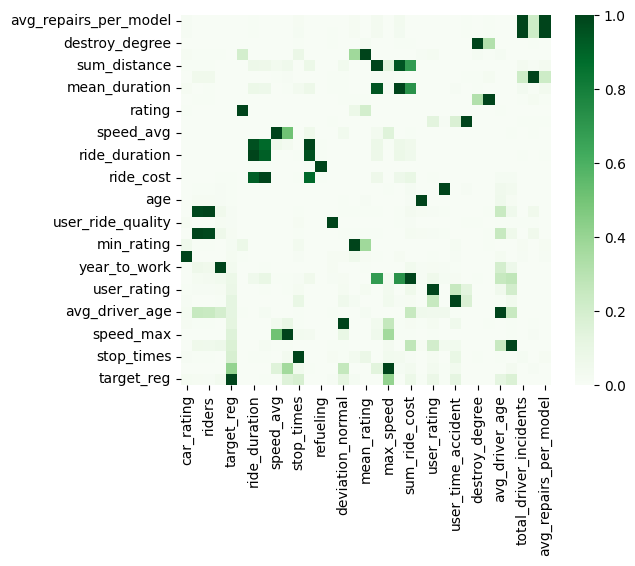

In [8]:
corrs = car_info.dropna().corr().round(3).sort_values('target_reg')
sns.heatmap(corrs,
            cmap = 'Greens',
            square=True,
            vmin = 0)

**CatBoost**

In [9]:
drop_cols = ['target_class', 'target_reg', 'ride_date', 'worker_id']
cat_cols = ['car_type', 'fuel_type', 'model', 'work_type']

X = car_info.drop(drop_cols, axis=1, errors = 'ignore')
y = car_info['target_class'].fillna(0)

In [10]:
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor, Pool, CatBoostClassifier
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
model = CatBoostClassifier(random_state=42,
                           cat_features=cat_cols,
                           thread_count=-1,
                           iterations=100)
model.fit(X_train, y_train,
          eval_set=(X_test, y_test),
          verbose=100, plot=False,
          early_stopping_rounds=100)
fi = model.get_feature_importance(prettified=True)

Learning rate set to 0.295307
0:	learn: 1.0643667	test: 1.0606179	best: 1.0606179 (0)	total: 5.04s	remaining: 8m 18s
99:	learn: 0.0555025	test: 0.0560933	best: 0.0560933 (99)	total: 9m 20s	remaining: 0us

bestTest = 0.05609325765
bestIteration = 99



In [14]:
fi

,Feature Id,Importances
0,max_speed,24.521301
1,mean_rating,24.056312
2,min_rating,8.682176
3,riders,6.556096
4,car_rating,4.770814
5,destroy_degree,3.834316
6,sum_distance,3.580617
7,year_to_work,3.315972
8,mean_duration,3.273309
9,sum_ride_cost,2.906877


**Permutation importance**

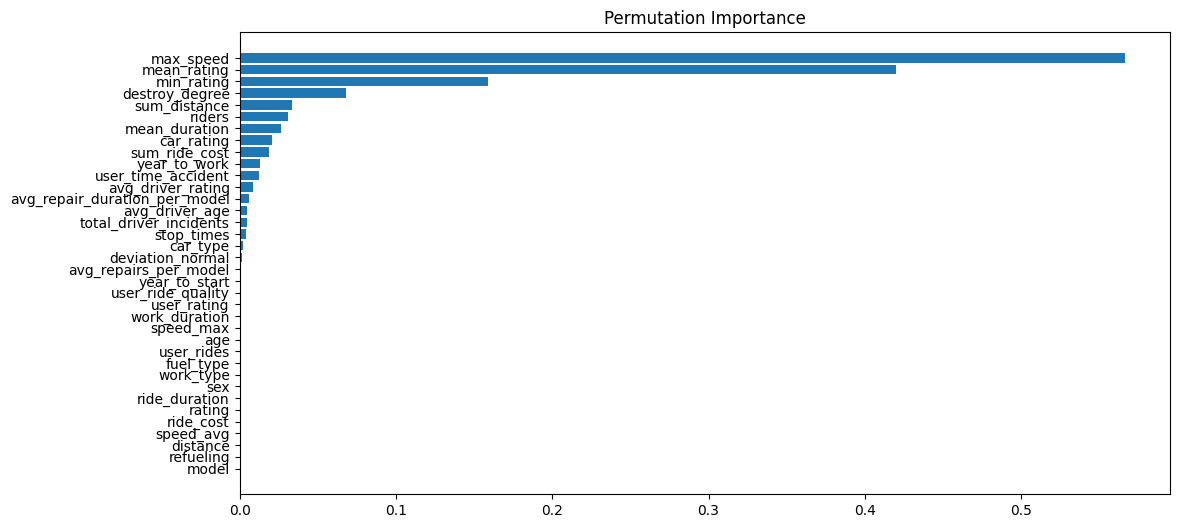

In [15]:
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(model, X_test, y_test, n_repeats=5, random_state=1066)
sorted_idx = perm_importance.importances_mean.argsort()
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X.columns)[sorted_idx])
plt.title('Permutation Importance');

Стоит отметить, что ТОП-3 фичей совпадают для каждого из представленных методов: максимальная скорость, средний рейтинг и минимальный рейтинг. Данные признаки были получены нами на предыдущем шаге, что демонстрирует высокую степень влияния Feature Engineering на результаты обучения. Наблюдается большое количество признаков, которые никак не коррелируют с нашей целевой переменной, что довольно логично с учетом большого набора признаков. Датасет нуждается в дальнейшей очистке.

# Домашнее задание 2. Прогноз времени и вида поломки машин. Настройка ML-модели

<div class="alert alert-info">

**Цель блока** — составить тренировочную и валидационную выборки, произвести обучение модели `CatBoostClassifier` на тренировочной части и оценить качество на валидационной.

##Обучение первой модели (5 баллов)

1.   Новый пункт
2.   Новый пункт



1. Классифицируйте признаки на типы (категориальные, числовые, таргеты).

2. Выделите в `X` только признаки, а в `Y` — таргет (для задачи классификации).

3. Сделайте разделение данных на *обучающую* и *валидационную* выборки (не забывайте про воспроизводимость результатов).

4. Создайте и обучите `CatBoostClassifier` модель (настраивать гиперпараметры сейчас не обязательно).

5. Проведите оценку вашей модели, используя метрику `accuracy`.


<h4> Критерии оценивания </h4>
    
- По 1 баллу за каждый корректно выполненный пункт.

</div>

In [ ]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [ ]:
features2drop = [...] # то, что надо выбросить
targets = [...] # таргеты
cat_features = [...] # категориальные признаки

num_features = [...] # числовые признаки

print('Категориальные признаки:', len(cat_features), cat_features)
print('Числовые признаки:', len(num_features), num_features)
print('Целевые переменные', targets)

In [ ]:
# YOUR CODE HERE

# Дополнительное задание. Визуализация прогнозов, ошибок модели и важности признаков

<div class="alert alert-info">

**Цель блока** — визуализировать результаты прогнозирования, ошибки модели и важность признаков для лучшего понимания и анализа модели.

## Визуализация (5 баллов)

   
1. Визуализируйте важность признаков встроенным методом в `CatBoost`  (помните, что не стоит сильно доверять этому рейтингу важности, т. к. для сильно скоррелированных признаков важность делится пополам — оба признака могут улететь вниз).

2. Постройте `waterfall_plot` из библиотеки `SHAP` (подробнее во втором ноутбуке из полезных ссылок ниже).
    
3. Постройте `classification_report` из библиотеки `scikit-learn`.

4. Постройте и визуализируйте матрицу смежности (`confusion_matrix`), посмотрите, в каких классах модель больше всего ошибается.
    
5. Для каждого графика/примененного метода проинтерпретируйте результаты и сделайте выводы.


<h4> Критерии оценивания </h4>
    
- По 1 баллу за каждый корректно выполненный пункт.
    
</div>

<div class="alert alert-success">

Визуализация может помочь даже после того, как мы **уже обучили** какую-нибудь модель. Например:

- Понять, что мешает модели или чего не хватает, чтобы не допускать ошибки.
- Сделать выводы, как можно улучшить точность в последующих экспериментах.
- Визуализировать ошибки модели.
- Отсеять лишние признаки.
- Найти идеи для новых признаков.
- Все зависит от типа ваших данных.

<h3> Полезные источники </h3>
    
- Занятие про визуализацию и Seaborn.
- Занятие про продвинутую визуализацию и анализ ошибок модели.

</div>    

In [ ]:
# YOUR CODE HERE

# Домашнее задание 3. Оптимизация. Тюнинг гиперпараметров с помощью `Optuna`

<div class="alert alert-info">

**Цель блока** — улучшить качество предсказания, произведя подбор гиперпараметров для модели с помощью `Optuna`.

## Подбор гиперпараметров (3 балла)

1. Напишите `objective` функцию и запустите `Optuna`.
2. Подберите гиперпараметры для `CatBoostClassifier` (минимум 3).
3. Обучите модель с новыми гиперпараметрами, сравните качество и сделайте выводы.

    
<h4> Критерии оценивания </h4>
    
- 1 балл за каждый корректно выполненный пункт.
    
</div>

In [ ]:
# YOUR CODE HERE

### Общая информация по `Optuna`

#### Ключевые особенности <code>Optuna</code>



- Легковесность и универсальность — можно подбирать оптимальные параметры под любые функции и метрики.
- SOTA-алгоритмы, адаптированные для поиска гиперпараметров.
- Параллелизация и различные методы прунинга.
- Встроенная визуализация.
- Интеграция со множеством популярных библиотек (бустинги, sklearn, PyTorch, W&B и другие).

Разберем Optuna по частям, чтобы понять, как ее использовать.

#### <code>Study</code>: оптимизация, базирующаяся на <code>Objective</code> функции



В `Objective`-функцию нужно написать код подсчета метрики, которую возвращаем. `Objective` вызывается Optuna много раз для подбора лучших параметров.
```python
def objective(trial, ...):
    # calculate score...
    return score
```

<h4> <code>Trial</code> — одно выполнение <code>Objective</code>-функции</h4>

В `trial`-объекте мы передаем параметры для «перебора», используя для каждого типа свой метод. Например:

```python
# метод `suggest_float` показывает, что перебираем `float` значения, от 0 и до 1.5 границы
param = trial.suggest_float('param', 0, 1.5)

# Категориальное значение
loss_function = trial.suggest_categorical('loss', ['Logloss', 'CrossEntropy'])

# Целочисленное значение
depth = trial.suggest_int('depth', 5, 8)

# Равномерное распределение
learning_rate = trial.suggest_uniform('learning_rate', 0.0, 1.0)
```

#### `Study` parameters

Инициализируем объект `study`, который начнет перебор и сохранит в себе историю результатов.
Если мы стараемся увеличить метрику, а не уменьшить ошибку, то используем `create_study(direction='maximize')`.
```python
study = optuna.create_study()
study.optimize(objective, n_trials=10)
```

<div class="alert alert-info">
    
В [`Optuna`](https://optuna.readthedocs.io/en/stable/index.html) реализовано несколько методов (`sampler`) подбора параметров (в том числе классические):
* `GridSampler`
* `RandomSampler`
* `Tree-Structed Parzen Estimator` (`TPESampler` — самый популярный, дефолтный)
* `BruteForceSampler`
* [Другие 4 метода](https://optuna.readthedocs.io/en/stable/reference/samplers/index.html#module-optuna.samplers) (можно написать собственный семплер)

### Советы по перебору параметров

- Иметь понимание важности параметров.
- Число `iterations` лучше взять с запасом и зафиксировать, при этом ограничив через `early_stopping_rounds`.
- Подсмотреть или чувствовать диапазоны и шаг значений.
- Исключить то, что перебирать не нужно (`random_seed` , `eval_metric`, `thread_count` и прочее).
- Используйте информацию с прошлых попыток.

# Домашнее задание 4. Блендинг

<div class="alert alert-info">

**Цель блока** — улучшить качество предсказания, объединив несколько моделей вместе методом блендинга.

## Задание 6. Блендинг (10 баллов)

1. Построить и обучить модели:
    - `CatBoostClassifier`,
    - `LightGBMClassifier (goss)`,
    - `XGBoostClassifier (dart)`,
    - `RandomForestClassifier`.
2. Сделать предсказания каждой моделью, оценить качество.
3. Реализовать блендинг двумя способами, оценить качество и сравнить с предыдущим пунктом:
    - `Hard Voting` —  метод, при котором делаем голосование всех моделей и выбираем самый популярный класс.
    - `Soft Voting` —  метод, при котором мы складываем вероятности предсказания всех моделей по каждому классу и потом выбираем самый класс с максимальной суммой.
    
<h4> Критерии оценивания </h4>
    
- Обучены 4 модели — 1 балл за каждую обученную модель, всего 4 балла.
- Для модели проведен подбор гиперпараметров — 0,5 балла за каждый параметр, всего 2 балла.
- Сделаны предсказания каждой модели и оценено качество — 1 балл.
- Реализован `Hard Voting` — 1 балл.
- Реализован `Soft Voting` — 1 балл.
- Сделаны выводы — 1 балл.
    
</div>

In [ ]:
# YOUR CODE HERE

### Общая информация о блендинге

**Основная идея** — взять от каждого алгоритма лучшее и совместить несколько разных ML-моделей в одну.

Что это дает:
- Увеличивается обобщающая способность финальной модели и качество улучшается.
- Модель становится более стабильной, что позволяет не слететь на приватном лидерборде.

Особенно хорошо накидывает блендинг, если смешиваемые модели имеют разную природу — например, нейронные сети, kNN и решающие деревья. Они выучивают разные зависимости и хорошо дополняют друг друга.

</div>

# <center id="part6"> Отправка финального решения на лидерборд на Kaggle

<div class="alert alert-info">

**Цель блока** — сделать предсказание с помощью блендинга для тестовой части датасета, отправить результат [в соревнование на Kaggle](https://www.kaggle.com/competitions/competative-data-science-course-by-data-feeling/overview).

## Задание 8. Предсказание на тестовом датасете и отправка на Kaggle

1. Сделать предобработку для тестового датасета, присоединить к нему информацию из других датасетов и добавить признаки, которые генерировали для тренировочного датасета.
2. Сделать предсказания каждой моделью, которую хотите включить в ансамбль, но минимум их должно быть 3.
3. Сделать блендинг с помощью `Hard Voting` или `Soft Voting` на ваш выбор.
4. Сохранить результат предсказания в `csv` файл и отправить решение на Kaggle.
    
<h4> Критерии оценивания </h4>
    
- 0 баллов за задание, если итоговый скор на лидерборде меньше чем `0.9`.
- 1 балл за каждый выполненный пункт.

</div>

In [ ]:
car_test = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/car_test.csv')
car_test.head(3)

In [ ]:
# YOUR CODE HERE

### Советы по отправке кода на Kaggle



Если пишете код на `Kaggle`, то для отправки решения:

1. Нажать Save Version.
2. Проверить, что в Advanced Settings выбрано «Всегда сохранять результаты ноутбука».
3. Выбрать тип сохранения Save & Run All (Commit).
4. Нажать кнопку Save.